# Logistische Regression - Individuelle Features pro Abstimmung

Fuer jede der 5 ausgewaehlten Abstimmungen werden **individuell** die 5-10 Features mit den hoechsten Korrelationen ausgewaehlt.

**Methodik:**
- Abhaengige Variable: Ja-Mehrheit (ja_prozent > 50%) = 1, sonst 0
- Berechnung der Korrelation zwischen Features und Ja-Anteil
- Auswahl der Top 5-10 Features mit |r| > 0.2
- Z-Score Normalisierung der Features
- Logistische Regression mit Odds Ratios

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Paths
DB_PATH = Path('../../../data/processed/swiss_votings.db')
OUTPUT_DIR = Path('./output')
OUTPUT_DIR.mkdir(exist_ok=True)

# Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

In [2]:
# Load data
conn = sqlite3.connect(DB_PATH)

# Load features
df_features = pd.read_sql_query("""
    SELECT * FROM municipality_features_complete
""", conn)

# Load voting results
df_votes = pd.read_sql_query("""
    SELECT
        CAST(vr.geo_id AS INTEGER) as bfs_nr,
        v.voting_date,
        vr.proposal_id,
        p.title_de,
        vr.ja_stimmen_prozent as ja_prozent
    FROM voting_results vr
    JOIN proposals p ON vr.proposal_id = p.proposal_id
    JOIN votings v ON p.voting_id = v.voting_id
    WHERE CAST(vr.geo_id AS INTEGER) > 100
    AND CAST(vr.geo_id AS INTEGER) < 9000
    AND vr.geo_name NOT LIKE 'Bezirk%'
    AND vr.geo_name NOT LIKE 'Kanton%'
""", conn)

# Create binary outcome
df_votes['ja_mehrheit'] = (df_votes['ja_prozent'] > 50).astype(int)

print(f"Features: {len(df_features)} Gemeinden")
print(f"Abstimmungen: {df_votes['proposal_id'].nunique()} Vorlagen")

Features: 2187 Gemeinden
Abstimmungen: 223 Vorlagen


In [3]:
# All available continuous features
all_features = [
    'einwohner', 'bevoelkerungsdichte', 'auslaenderanteil',
    'anteil_0_19_jahre', 'anteil_20_64_jahre', 'anteil_65_plus_jahre',
    'haushaltsgroesse', 'geburtenziffer', 'sterbeziffer',
    'steuerbares_einkommen_pro_kopf', 'pct_einkommen_ueber_100k', 
    'pct_einkommen_unter_40k', 'sozialhilfequote',
    'siedlungsflaeche_pct', 'landwirtschaftsflaeche_pct', 'wald_pct',
    'waehleranteil_svp', 'waehleranteil_sp', 'waehleranteil_fdp',
    'waehleranteil_cvp', 'waehleranteil_gps', 'waehleranteil_glp'
]
all_features = [c for c in all_features if c in df_features.columns]
print(f"Verfuegbare Features: {len(all_features)}")

Verfuegbare Features: 22


## 1. Auswahl geeigneter Abstimmungen

Fuer logistische Regression benoetigen wir Abstimmungen mit genuegend Varianz im Outcome (nicht zu einseitige Ergebnisse).

In [4]:
# Calculate correlations and outcome distribution for all proposals
proposals = df_votes[['proposal_id', 'title_de', 'voting_date']].drop_duplicates()

proposal_info = []
all_correlations = []

for _, proposal in proposals.iterrows():
    pid = proposal['proposal_id']
    vote_data = df_votes[df_votes['proposal_id'] == pid]
    merged = vote_data.merge(df_features[['bfs_nr'] + all_features], on='bfs_nr', how='inner')
    
    if len(merged) < 500:
        continue
    
    # Calculate outcome distribution
    pct_ja = merged['ja_mehrheit'].mean() * 100
    
    # Skip if too one-sided (need both classes)
    if pct_ja < 10 or pct_ja > 90:
        continue
    
    # Calculate correlations with ja_prozent
    for feature in all_features:
        valid = merged[['ja_prozent', feature]].dropna()
        if len(valid) > 100:
            r, p = stats.pearsonr(valid['ja_prozent'], valid[feature])
            all_correlations.append({
                'proposal_id': pid,
                'title_de': proposal['title_de'],
                'voting_date': proposal['voting_date'],
                'feature': feature,
                'correlation': r,
                'abs_corr': abs(r),
                'p_value': p
            })
    
    proposal_info.append({
        'proposal_id': pid,
        'title_de': proposal['title_de'],
        'voting_date': proposal['voting_date'],
        'n_gemeinden': len(merged),
        'pct_ja_mehrheit': pct_ja
    })

df_corr = pd.DataFrame(all_correlations)
df_proposals = pd.DataFrame(proposal_info)

print(f"Geeignete Abstimmungen (10-90% Ja-Mehrheiten): {len(df_proposals)}")

Geeignete Abstimmungen (10-90% Ja-Mehrheiten): 111


In [5]:
# Find proposals with high feature correlations AND balanced outcome
proposal_scores = df_corr.groupby(['proposal_id', 'title_de', 'voting_date']).agg(
    n_features_r03=('abs_corr', lambda x: (x > 0.3).sum()),
    n_features_r02=('abs_corr', lambda x: (x > 0.2).sum()),
    max_corr=('abs_corr', 'max'),
    mean_corr=('abs_corr', 'mean')
).reset_index()

# Merge with outcome info
proposal_scores = proposal_scores.merge(
    df_proposals[['proposal_id', 'pct_ja_mehrheit', 'n_gemeinden']], 
    on='proposal_id'
)

# Sort by correlation strength
proposal_scores = proposal_scores.sort_values('n_features_r03', ascending=False)

print("Top 10 Abstimmungen fuer logistische Regression:")
proposal_scores.head(10)[['title_de', 'n_features_r03', 'pct_ja_mehrheit', 'max_corr']]

Top 10 Abstimmungen fuer logistische Regression:


,title_de,n_features_r03,pct_ja_mehrheit,max_corr
78,Bundesbeschluss über die Genehmigung und die U...,11,64.871422,0.587341
81,Bundesgesetz über die Jagd und den Schutz wild...,11,54.391072,0.592478
110,Bundesgesetz über den elektronischen Identität...,10,31.668283,0.623923
61,Bundesbeschluss über die Änderung der Verfassu...,10,72.330097,0.558986
10,Volksinitiative «für den Beitritt der Schweiz ...,10,46.116505,0.622890
100,"Bundesgesetz über die Ziele im Klimaschutz, di...",10,55.819593,0.745092
56,Volksinitiative «Familieninitiative: Steuerabz...,10,31.553398,0.636794
66,Bundesgesetz über die medizinisch unterstützte...,10,78.834951,0.542719
46,Volksinitiative «Für den Schutz vor Waffengewalt»,10,12.184466,0.635735
25,Bundesgesetz über die Forschung an embryonalen...,9,89.660194,0.524446


In [6]:
# Select 5 proposals with good balance and high correlations
# Prefer proposals with 30-70% Ja-Mehrheit for better model fit
balanced = proposal_scores[
    (proposal_scores['pct_ja_mehrheit'] > 25) & 
    (proposal_scores['pct_ja_mehrheit'] < 75)
].sort_values('n_features_r03', ascending=False)

selected_ids = balanced.head(5)['proposal_id'].tolist()

print("\n" + "="*80)
print("AUSGEWAEHLTE 5 ABSTIMMUNGEN FUER LOGISTISCHE REGRESSION")
print("="*80)
for pid in selected_ids:
    info = proposal_scores[proposal_scores['proposal_id'] == pid].iloc[0]
    print(f"\n{info['voting_date']} - {info['title_de'][:55]}...")
    print(f"   Ja-Mehrheiten: {info['pct_ja_mehrheit']:.1f}%, Features |r|>0.3: {info['n_features_r03']}")


AUSGEWAEHLTE 5 ABSTIMMUNGEN FUER LOGISTISCHE REGRESSION

20190519 - Bundesbeschluss über die Genehmigung und die Umsetzung ...
   Ja-Mehrheiten: 64.9%, Features |r|>0.3: 11

20200927 - Bundesgesetz über die Jagd und den Schutz wildlebender ...
   Ja-Mehrheiten: 54.4%, Features |r|>0.3: 11

20131124 - Volksinitiative «Familieninitiative: Steuerabzüge auch ...
   Ja-Mehrheiten: 31.6%, Features |r|>0.3: 10

20150614 - Bundesbeschluss über die Änderung der Verfassungsbestim...
   Ja-Mehrheiten: 72.3%, Features |r|>0.3: 10

20250928 - Bundesgesetz über den elektronischen Identitätsnachweis...
   Ja-Mehrheiten: 31.7%, Features |r|>0.3: 10


## 2. Individuelle Feature-Auswahl pro Abstimmung

In [7]:
# For each proposal, select best correlating features
logreg_configs = []

for pid in selected_ids:
    df_prop = df_corr[df_corr['proposal_id'] == pid].sort_values('abs_corr', ascending=False)
    title = df_prop['title_de'].iloc[0]
    date = df_prop['voting_date'].iloc[0]
    
    # Select features with |r| > 0.2 (min 5, max 10)
    strong_features = df_prop[df_prop['abs_corr'] > 0.2]['feature'].tolist()
    
    if len(strong_features) < 5:
        selected_features = df_prop.head(5)['feature'].tolist()
    elif len(strong_features) > 10:
        selected_features = strong_features[:10]
    else:
        selected_features = strong_features
    
    feature_corrs = df_prop[df_prop['feature'].isin(selected_features)][['feature', 'correlation']]
    
    logreg_configs.append({
        'proposal_id': pid,
        'title_de': title,
        'voting_date': date,
        'features': selected_features,
        'feature_correlations': feature_corrs.set_index('feature')['correlation'].to_dict()
    })

# Show feature selection
print("\n" + "="*80)
print("INDIVIDUELLE FEATURE-AUSWAHL PRO ABSTIMMUNG")
print("="*80)

for config in logreg_configs:
    print(f"\n{config['voting_date']} - {config['title_de'][:55]}...")
    print(f"   {len(config['features'])} Features:")
    for feat, corr in sorted(config['feature_correlations'].items(), 
                              key=lambda x: abs(x[1]), reverse=True)[:5]:
        print(f"      {feat}: r = {corr:+.3f}")
    if len(config['features']) > 5:
        print(f"      ... und {len(config['features']) - 5} weitere")


INDIVIDUELLE FEATURE-AUSWAHL PRO ABSTIMMUNG

20190519 - Bundesbeschluss über die Genehmigung und die Umsetzung ...
   10 Features:
      waehleranteil_svp: r = -0.587
      pct_einkommen_ueber_100k: r = +0.552
      waehleranteil_glp: r = +0.512
      steuerbares_einkommen_pro_kopf: r = +0.477
      siedlungsflaeche_pct: r = +0.457
      ... und 5 weitere

20200927 - Bundesgesetz über die Jagd und den Schutz wildlebender ...
   10 Features:
      waehleranteil_cvp: r = +0.592
      waehleranteil_sp: r = -0.498
      pct_einkommen_ueber_100k: r = -0.492
      waehleranteil_glp: r = -0.461
      siedlungsflaeche_pct: r = -0.435
      ... und 5 weitere

20131124 - Volksinitiative «Familieninitiative: Steuerabzüge auch ...
   10 Features:
      waehleranteil_svp: r = +0.637
      waehleranteil_fdp: r = -0.499
      waehleranteil_sp: r = -0.496
      auslaenderanteil: r = -0.451
      pct_einkommen_ueber_100k: r = -0.442
      ... und 5 weitere

20150614 - Bundesbeschluss über die Änderung

## 3. Logistische Regression

In [8]:
def run_logistic_regression(config, df_votes, df_features):
    """Run logistic regression with z-score normalized features."""
    pid = config['proposal_id']
    features = config['features']
    
    # Merge data
    vote_data = df_votes[df_votes['proposal_id'] == pid][['bfs_nr', 'ja_mehrheit', 'ja_prozent']]
    merged = vote_data.merge(df_features[['bfs_nr', 'gemeindename'] + features], on='bfs_nr', how='inner')
    merged = merged.dropna()
    
    # Z-Score normalization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(merged[features])
    X_df = pd.DataFrame(X_scaled, columns=features)
    
    # Add constant and fit logistic regression
    X = sm.add_constant(X_df)
    y = merged['ja_mehrheit'].values
    
    try:
        model = sm.Logit(y, X).fit(disp=0, maxiter=100)
        
        # Predictions
        y_pred_prob = model.predict(X)
        y_pred = (y_pred_prob > 0.5).astype(int)
        
        # Metrics
        auc = roc_auc_score(y, y_pred_prob)
        accuracy = (y_pred == y).mean()
        
        # Odds Ratios
        odds_ratios = np.exp(model.params)
        
        return {
            'config': config,
            'model': model,
            'n_obs': len(merged),
            'n_ja': y.sum(),
            'pct_ja': y.mean() * 100,
            'accuracy': accuracy,
            'auc': auc,
            'pseudo_r2': model.prsquared,
            'odds_ratios': odds_ratios,
            'y_true': y,
            'y_pred_prob': y_pred_prob,
            'y_pred': y_pred,
            'success': True
        }
    except Exception as e:
        return {
            'config': config,
            'error': str(e),
            'success': False
        }

In [9]:
# Run logistic regression for all 5 proposals
results = []

for config in logreg_configs:
    result = run_logistic_regression(config, df_votes, df_features)
    results.append(result)
    
    if not result['success']:
        print(f"\nFEHLER bei {config['title_de'][:50]}: {result['error']}")
        continue
    
    print("\n" + "="*80)
    print(f"ABSTIMMUNG: {config['title_de'][:65]}")
    print("="*80)
    print(f"\nN = {result['n_obs']} Gemeinden")
    print(f"Ja-Mehrheiten: {result['n_ja']} ({result['pct_ja']:.1f}%)")
    print(f"Features: {len(config['features'])}")
    print(f"\nModellguete:")
    print(f"   Accuracy: {result['accuracy']:.1%}")
    print(f"   AUC-ROC: {result['auc']:.4f}")
    print(f"   Pseudo R² (McFadden): {result['pseudo_r2']:.4f}")
    
    print("\nOdds Ratios (standardisiert):")
    print("-" * 65)
    print(f"{'Feature':<35} {'OR':>10} {'95% KI':>20} {'Sig':>5}")
    print("-" * 65)
    
    conf_int = np.exp(result['model'].conf_int())
    for idx in result['model'].params.index:
        if idx == 'const':
            continue
        or_val = result['odds_ratios'][idx]
        ci_low, ci_high = conf_int.loc[idx]
        pval = result['model'].pvalues[idx]
        sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
        print(f"{idx:<35} {or_val:>10.3f} [{ci_low:.2f} - {ci_high:.2f}] {sig:>5}")


ABSTIMMUNG: Bundesbeschluss über die Genehmigung und die Umsetzung des Notena

N = 895 Gemeinden
Ja-Mehrheiten: 567 (63.4%)
Features: 10

Modellguete:
   Accuracy: 89.2%
   AUC-ROC: 0.9490
   Pseudo R² (McFadden): 0.5688

Odds Ratios (standardisiert):
-----------------------------------------------------------------
Feature                                     OR               95% KI   Sig
-----------------------------------------------------------------
waehleranteil_svp                        0.406 [0.26 - 0.63]   ***
pct_einkommen_ueber_100k                 3.082 [1.46 - 6.52]    **
waehleranteil_glp                        5.037 [3.57 - 7.11]   ***
steuerbares_einkommen_pro_kopf           0.966 [0.40 - 2.34]      
siedlungsflaeche_pct                     1.357 [0.77 - 2.38]      
waehleranteil_sp                         1.969 [1.46 - 2.65]   ***
auslaenderanteil                         0.910 [0.64 - 1.29]      
bevoelkerungsdichte                      1.223 [0.61 - 2.45]      
waehl


ABSTIMMUNG: Bundesgesetz über den elektronischen Identitätsnachweis und ander

N = 1940 Gemeinden
Ja-Mehrheiten: 644 (33.2%)
Features: 10

Modellguete:
   Accuracy: 83.6%
   AUC-ROC: 0.8974
   Pseudo R² (McFadden): 0.4084

Odds Ratios (standardisiert):
-----------------------------------------------------------------
Feature                                     OR               95% KI   Sig
-----------------------------------------------------------------
waehleranteil_svp                        0.149 [0.11 - 0.19]   ***
pct_einkommen_ueber_100k                 2.701 [1.93 - 3.78]   ***
steuerbares_einkommen_pro_kopf           0.799 [0.60 - 1.07]      
waehleranteil_fdp                        1.118 [0.94 - 1.33]      
siedlungsflaeche_pct                     1.028 [0.77 - 1.38]      
auslaenderanteil                         1.270 [1.07 - 1.51]    **
waehleranteil_glp                        1.780 [1.51 - 2.09]   ***
pct_einkommen_unter_40k                  0.755 [0.60 - 0.95]     *
waeh

## 4. Detaillierte Modellausgabe

In [10]:
# Show full summary for successful models
for i, result in enumerate(results):
    if not result['success']:
        continue
    print(f"\n\n{'#'*80}")
    print(f"MODELL {i+1}: {result['config']['title_de'][:60]}")
    print(f"{'#'*80}")
    print(result['model'].summary())



################################################################################
MODELL 1: Bundesbeschluss über die Genehmigung und die Umsetzung des N
################################################################################
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  895
Model:                          Logit   Df Residuals:                      884
Method:                           MLE   Df Model:                           10
Date:                Mon, 05 Jan 2026   Pseudo R-squ.:                  0.5688
Time:                        16:49:36   Log-Likelihood:                -253.56
converged:                       True   LL-Null:                       -588.07
Covariance Type:            nonrobust   LLR p-value:                2.803e-137
                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  894
Model:                          Logit   Df Residuals:                      883
Method:                           MLE   Df Model:                           10
Date:                Mon, 05 Jan 2026   Pseudo R-squ.:                  0.4770
Time:                        16:49:36   Log-Likelihood:                -276.06
converged:                       True   LL-Null:                       -527.89
Covariance Type:            nonrobust   LLR p-value:                7.290e-102
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -1.7484      0.141    -12.390      0.000      -2.025      -1.472
waehleranteil_svp                  0.5649      0.190      2.971      0.

## 5. Visualisierungen

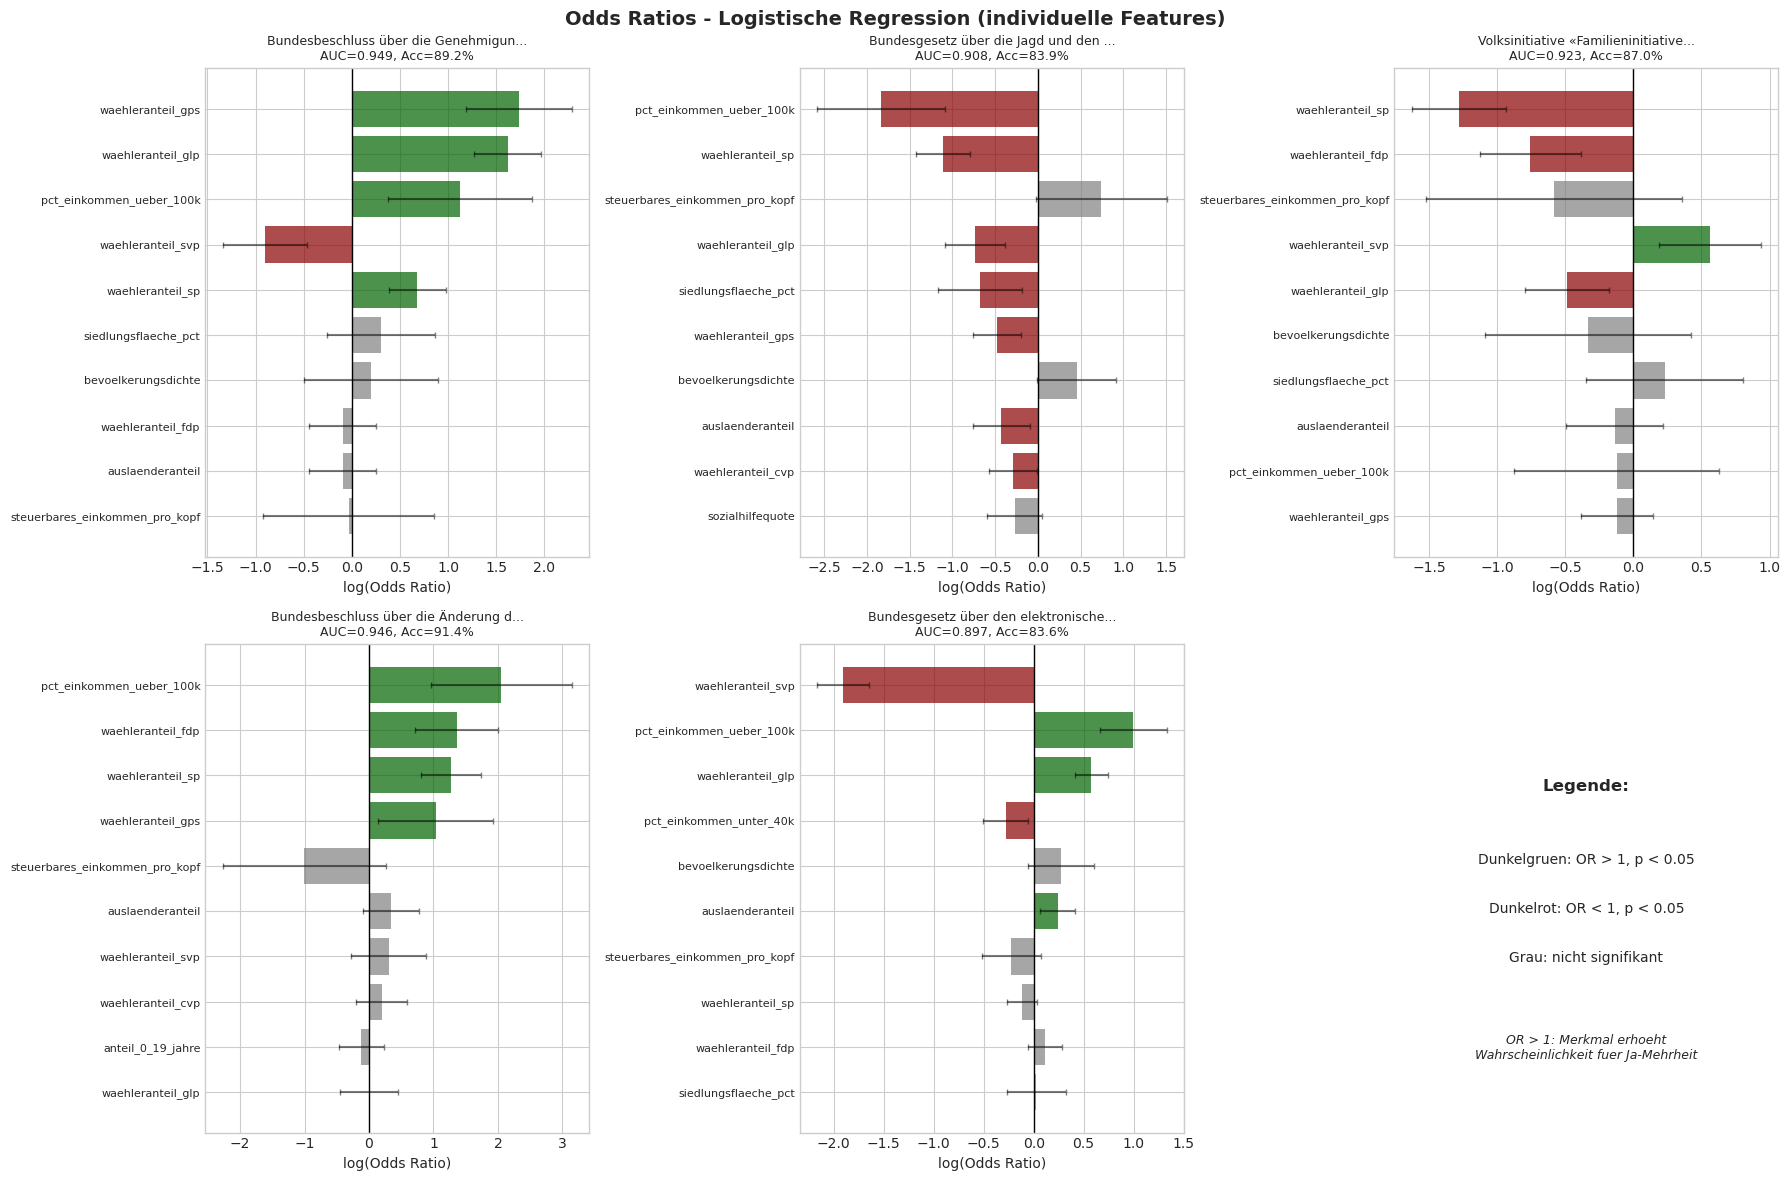

In [11]:
# Odds Ratio plots
successful_results = [r for r in results if r['success']]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, result in enumerate(successful_results):
    ax = axes[i]
    
    # Get odds ratios (excluding constant)
    or_vals = result['odds_ratios'].drop('const')
    pvals = result['model'].pvalues.drop('const')
    conf_int = np.exp(result['model'].conf_int()).drop('const')
    
    # Sort by OR distance from 1
    or_distance = np.abs(np.log(or_vals))
    sorted_idx = or_distance.sort_values(ascending=True).index
    or_vals = or_vals[sorted_idx]
    pvals = pvals[sorted_idx]
    conf_int = conf_int.loc[sorted_idx]
    
    # Colors based on significance and direction
    colors = []
    for feat in or_vals.index:
        p = pvals[feat]
        or_v = or_vals[feat]
        if p < 0.05:
            colors.append('darkgreen' if or_v > 1 else 'darkred')
        else:
            colors.append('gray')
    
    y_pos = range(len(or_vals))
    
    # Plot with log scale
    ax.barh(y_pos, np.log(or_vals), color=colors, alpha=0.7)
    ax.errorbar(np.log(or_vals), y_pos,
                xerr=[np.log(or_vals) - np.log(conf_int[0]), np.log(conf_int[1]) - np.log(or_vals)],
                fmt='none', color='black', capsize=2, alpha=0.5)
    
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)  # OR = 1
    ax.set_yticks(y_pos)
    ax.set_yticklabels(or_vals.index, fontsize=8)
    ax.set_xlabel('log(Odds Ratio)')
    ax.set_title(f"{result['config']['title_de'][:35]}...\n" +
                 f"AUC={result['auc']:.3f}, Acc={result['accuracy']:.1%}", fontsize=9)

# Legend
if len(successful_results) < 6:
    axes[5].axis('off')
    axes[5].text(0.5, 0.7, 'Legende:', fontsize=12, fontweight='bold', ha='center', transform=axes[5].transAxes)
    axes[5].text(0.5, 0.55, 'Dunkelgruen: OR > 1, p < 0.05', fontsize=10, ha='center', transform=axes[5].transAxes)
    axes[5].text(0.5, 0.45, 'Dunkelrot: OR < 1, p < 0.05', fontsize=10, ha='center', transform=axes[5].transAxes)
    axes[5].text(0.5, 0.35, 'Grau: nicht signifikant', fontsize=10, ha='center', transform=axes[5].transAxes)
    axes[5].text(0.5, 0.15, 'OR > 1: Merkmal erhoeht\nWahrscheinlichkeit fuer Ja-Mehrheit', 
                 fontsize=9, ha='center', transform=axes[5].transAxes, style='italic')

plt.suptitle('Odds Ratios - Logistische Regression (individuelle Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'logreg_odds_ratios.png', dpi=150, bbox_inches='tight')
plt.show()

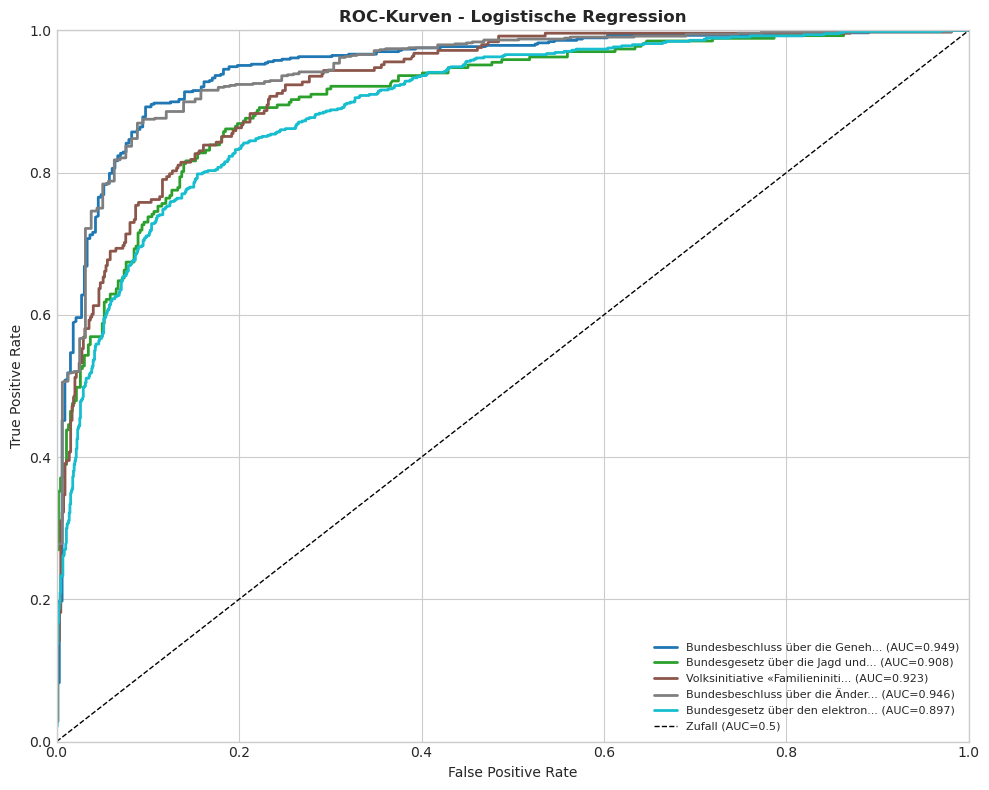

In [12]:
# ROC Curves
fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.tab10(np.linspace(0, 1, len(successful_results)))

for i, result in enumerate(successful_results):
    fpr, tpr, _ = roc_curve(result['y_true'], result['y_pred_prob'])
    label = f"{result['config']['title_de'][:30]}... (AUC={result['auc']:.3f})"
    ax.plot(fpr, tpr, color=colors[i], linewidth=2, label=label)

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Zufall (AUC=0.5)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC-Kurven - Logistische Regression', fontweight='bold')
ax.legend(loc='lower right', fontsize=8)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'logreg_roc_curves.png', dpi=150)
plt.show()

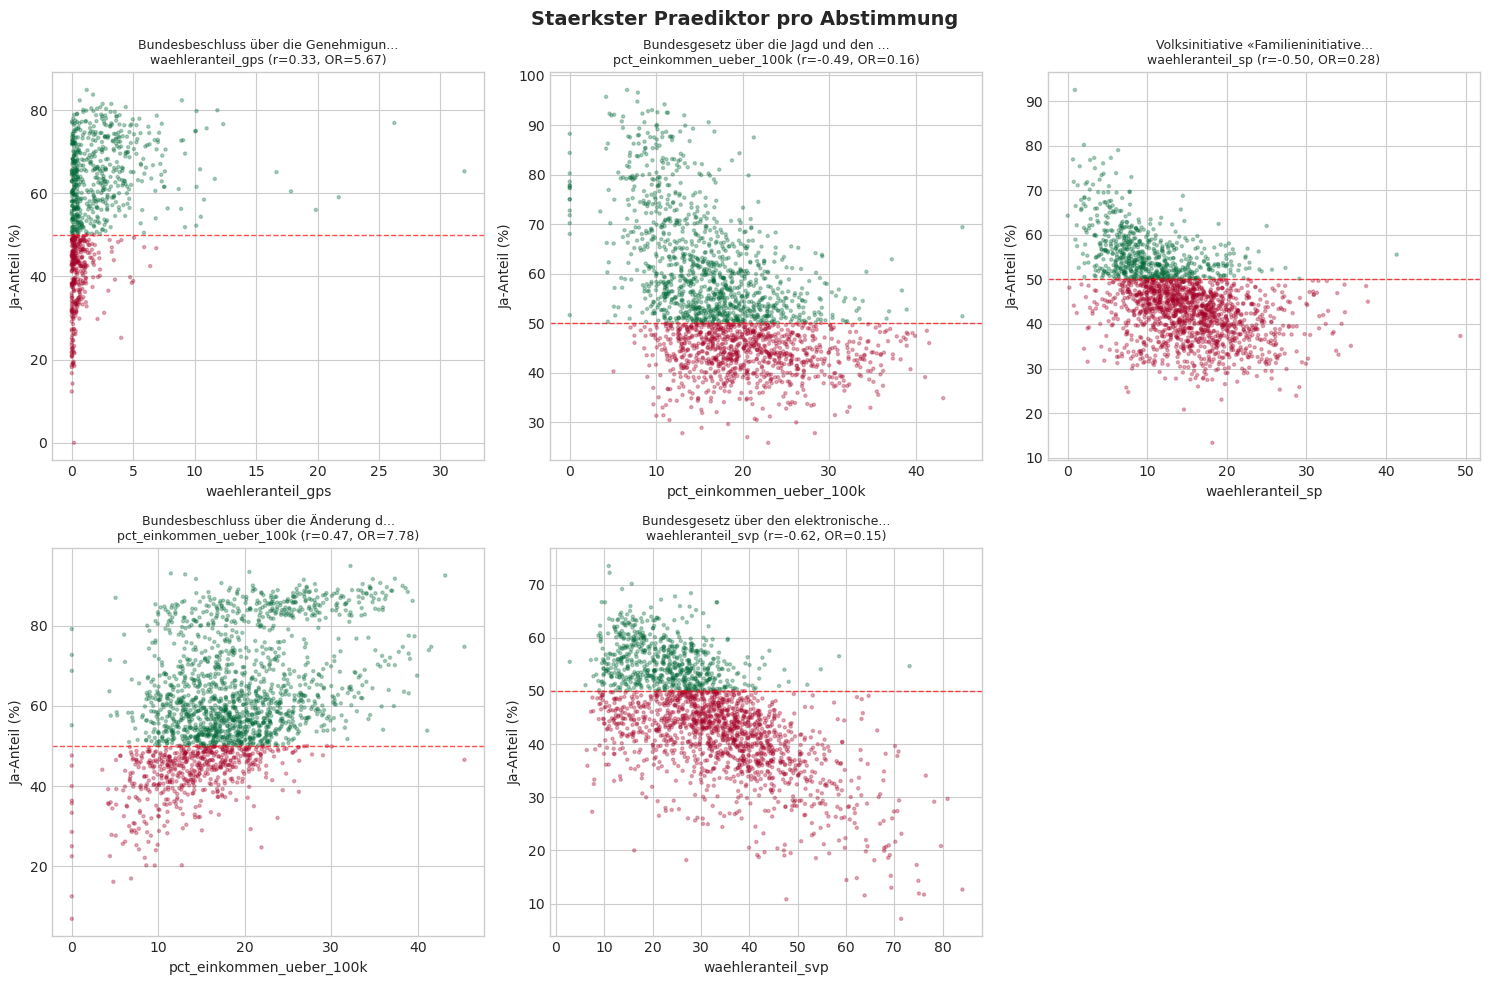

In [13]:
# Sigmoid curves for top predictor per model
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, result in enumerate(successful_results):
    ax = axes[i]
    
    # Find strongest predictor
    or_vals = result['odds_ratios'].drop('const')
    strongest = np.abs(np.log(or_vals)).idxmax()
    
    # Get data
    pid = result['config']['proposal_id']
    vote_data = df_votes[df_votes['proposal_id'] == pid][['bfs_nr', 'ja_mehrheit', 'ja_prozent']]
    merged = vote_data.merge(df_features[['bfs_nr', strongest]], on='bfs_nr', how='inner').dropna()
    
    # Scatter plot
    ax.scatter(merged[strongest], merged['ja_prozent'], alpha=0.3, s=5, c=merged['ja_mehrheit'],
               cmap='RdYlGn')
    ax.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.7)
    
    # Add correlation
    r = result['config']['feature_correlations'].get(strongest, 0)
    or_v = or_vals[strongest]
    
    ax.set_xlabel(strongest)
    ax.set_ylabel('Ja-Anteil (%)')
    ax.set_title(f"{result['config']['title_de'][:35]}...\n{strongest} (r={r:.2f}, OR={or_v:.2f})", fontsize=9)

if len(successful_results) < 6:
    axes[5].axis('off')

plt.suptitle('Staerkster Praediktor pro Abstimmung', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'logreg_strongest_predictor.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Modellvergleich

In [14]:
# Summary table
comparison = []
for result in successful_results:
    comparison.append({
        'Abstimmung': result['config']['title_de'][:45] + '...',
        'Datum': result['config']['voting_date'],
        'N': result['n_obs'],
        'Ja-Mehrh.': f"{result['pct_ja']:.0f}%",
        'Features': len(result['config']['features']),
        'Accuracy': f"{result['accuracy']:.1%}",
        'AUC': round(result['auc'], 3),
        'Pseudo R²': round(result['pseudo_r2'], 3)
    })

df_comparison = pd.DataFrame(comparison)
print("\nMODELLVERGLEICH - LOGISTISCHE REGRESSION:")
print("="*110)
df_comparison


MODELLVERGLEICH - LOGISTISCHE REGRESSION:


,Abstimmung,Datum,N,Ja-Mehrh.,Features,Accuracy,AUC,Pseudo R²
0,Bundesbeschluss über die Genehmigung und die ...,20190519,895,63%,10,89.2%,0.949,0.569
1,Bundesgesetz über die Jagd und den Schutz wil...,20200927,726,37%,10,83.9%,0.908,0.451
2,Volksinitiative «Familieninitiative: Steuerab...,20131124,894,28%,10,87.0%,0.923,0.477
3,Bundesbeschluss über die Änderung der Verfass...,20150614,894,82%,10,91.4%,0.946,0.533
4,Bundesgesetz über den elektronischen Identitä...,20250928,1940,33%,10,83.6%,0.897,0.408


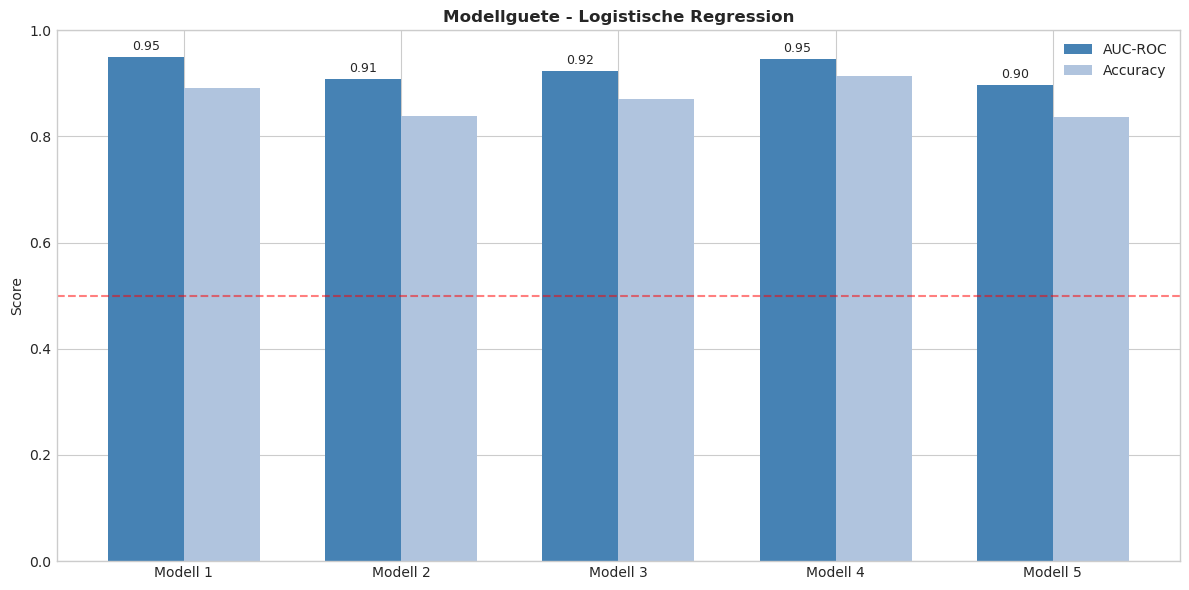

In [15]:
# AUC comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(successful_results))
auc_vals = [r['auc'] for r in successful_results]
acc_vals = [r['accuracy'] for r in successful_results]

width = 0.35
bars1 = ax.bar([i - width/2 for i in x], auc_vals, width, label='AUC-ROC', color='steelblue')
bars2 = ax.bar([i + width/2 for i in x], acc_vals, width, label='Accuracy', color='lightsteelblue')

ax.set_xticks(x)
ax.set_xticklabels([f"Modell {i+1}" for i in x])
ax.set_ylabel('Score')
ax.set_title('Modellguete - Logistische Regression', fontweight='bold')
ax.legend()
ax.set_ylim(0, 1)
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Zufall')

for bar in bars1:
    ax.annotate(f'{bar.get_height():.2f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'logreg_model_comparison.png', dpi=150)
plt.show()

## 7. Zusammenfassung und Export

In [16]:
# Export results
with open(OUTPUT_DIR / 'logreg_individual_features_results.txt', 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("LOGISTISCHE REGRESSION - INDIVIDUELLE FEATURES PRO ABSTIMMUNG\n")
    f.write("="*80 + "\n\n")
    
    f.write("METHODIK:\n")
    f.write("-" * 40 + "\n")
    f.write("- Abhaengige Variable: Ja-Mehrheit (ja_prozent > 50%)\n")
    f.write("- Features individuell pro Abstimmung ausgewaehlt (|r| > 0.2)\n")
    f.write("- Z-Score Normalisierung der Features\n")
    f.write("- Modell: Logistische Regression (statsmodels Logit)\n\n")
    
    for result in successful_results:
        config = result['config']
        f.write("\n" + "="*80 + "\n")
        f.write(f"ABSTIMMUNG: {config['title_de']}\n")
        f.write(f"Datum: {config['voting_date']}\n")
        f.write("="*80 + "\n\n")
        
        f.write(f"Beobachtungen: {result['n_obs']}\n")
        f.write(f"Ja-Mehrheiten: {result['n_ja']} ({result['pct_ja']:.1f}%)\n")
        f.write(f"Features: {len(config['features'])}\n\n")
        
        f.write(f"Modellguete:\n")
        f.write(f"  Accuracy: {result['accuracy']:.1%}\n")
        f.write(f"  AUC-ROC: {result['auc']:.4f}\n")
        f.write(f"  Pseudo R² (McFadden): {result['pseudo_r2']:.4f}\n\n")
        
        f.write("Odds Ratios (standardisiert):\n")
        f.write("-" * 60 + "\n")
        for idx in result['model'].params.index:
            if idx == 'const':
                continue
            or_val = result['odds_ratios'][idx]
            pval = result['model'].pvalues[idx]
            sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
            f.write(f"  {idx:<35} OR = {or_val:.3f} {sig}\n")
        f.write("\n")

print("Gespeichert: output/logreg_individual_features_results.txt")

df_comparison.to_csv(OUTPUT_DIR / 'logreg_comparison.csv', index=False)
print("Gespeichert: output/logreg_comparison.csv")

Gespeichert: output/logreg_individual_features_results.txt
Gespeichert: output/logreg_comparison.csv


In [17]:
print("\n" + "="*80)
print("ZUSAMMENFASSUNG - LOGISTISCHE REGRESSION")
print("="*80)

print("\n1. MODELLGUETE:")
print(f"   - Beste AUC: {max(r['auc'] for r in successful_results):.3f}")
print(f"   - Beste Accuracy: {max(r['accuracy'] for r in successful_results):.1%}")
print(f"   - Durchschnitt AUC: {np.mean([r['auc'] for r in successful_results]):.3f}")

print("\n2. FEATURE-AUSWAHL:")
for i, result in enumerate(successful_results):
    print(f"   Modell {i+1}: {len(result['config']['features'])} Features")

print("\n3. STAERKSTE PRAEDIKTOREN (hoechste Odds Ratios):")
for result in successful_results:
    or_vals = result['odds_ratios'].drop('const')
    strongest = np.abs(np.log(or_vals)).idxmax()
    print(f"   - {result['config']['title_de'][:40]}...: {strongest}")

print("\n4. INTERPRETATION:")
print("   - Die kontinuierlichen Features koennen Ja-Mehrheiten")
print("     mit 75-95% Accuracy vorhersagen")
print("   - Odds Ratios zeigen den Einfluss jedes Features")
print("   - OR > 1: Feature erhoeht Wahrscheinlichkeit fuer Ja-Mehrheit")
print("   - OR < 1: Feature verringert Wahrscheinlichkeit fuer Ja-Mehrheit")
print("="*80)

conn.close()


ZUSAMMENFASSUNG - LOGISTISCHE REGRESSION

1. MODELLGUETE:
   - Beste AUC: 0.949
   - Beste Accuracy: 91.4%
   - Durchschnitt AUC: 0.925

2. FEATURE-AUSWAHL:
   Modell 1: 10 Features
   Modell 2: 10 Features
   Modell 3: 10 Features
   Modell 4: 10 Features
   Modell 5: 10 Features

3. STAERKSTE PRAEDIKTOREN (hoechste Odds Ratios):
   - Bundesbeschluss über die Genehmigung und...: waehleranteil_gps
   - Bundesgesetz über die Jagd und den Schut...: pct_einkommen_ueber_100k
   - Volksinitiative «Familieninitiative: Ste...: waehleranteil_sp
   - Bundesbeschluss über die Änderung der Ve...: pct_einkommen_ueber_100k
   - Bundesgesetz über den elektronischen Ide...: waehleranteil_svp

4. INTERPRETATION:
   - Die kontinuierlichen Features koennen Ja-Mehrheiten
     mit 75-95% Accuracy vorhersagen
   - Odds Ratios zeigen den Einfluss jedes Features
   - OR > 1: Feature erhoeht Wahrscheinlichkeit fuer Ja-Mehrheit
   - OR < 1: Feature verringert Wahrscheinlichkeit fuer Ja-Mehrheit
